# Project Report and Write-up



## High Level Overview

This project can be split up into two main components: the digitial communications portion and the deep learning portion. On one hand, the digital communications side of the project involves generating symbols based off a given modulation scheme, adding noise to that symbol, and calculating the Log-Likelihood Ratio (LLR) of ecah bit. On the other hand, a neural network is created in order to attempt to predict these LLRs only given the noisy constellation. Note that all the digital communications functions are implemented using MATLAB and fed into Python using .csv files.


## Generating the Data and Digital Communications Background

### Generating data

To create a random symbol vector, I utilized the randi() function in MATLAB to genenerate a vector with values in the range [1,M] where M is the modulation order. Then, using a pre-defined constellation map, each entry of this vector is mapped to the correct constellation. After this, complex AWGN noise is added and then we calculate the LLRs of each bit. Using three different MATLAB functions I implemented, I generated constellations and LLRS for: <br><br>
1) A single SNR channel<br>
2) A channel operating over a range of SNRs <br>
3) A channel operating over a single SNR which also incorporates fading. This fading affects the amplitude based off a parameter I call fade_var and the phase based off a uniform distribution over [0,2$\pi$]

### Calculating LLRs

The Log-Likelihood Ratio of a bit $i$ is defined by the equation below where $b_i$ is the original bit sent and $r$ is the input to the reciever:

$$ LLR_{b_i} = \log{\left( \frac{p(b_i = 0 | r)}{p(b_i = 1 | r)} \right)}$$

Applying Baye's Rule to this expression, we arrive at:

$$
\begin{align} LLR_{b_i} &= \log{\left( \frac{\frac{p(r | b_i = 0)p(b_i = 0)}{p(r)}}{\frac{p(r | b_i = 1)p(b_i = 1)}{p(r)}} \right)} \\
&= \log{\left( \frac{p(r | b_i = 0)p(b_i = 0)}{p(r |b_i = 1)p(b_i=1)} \right)} \\
&= \log{\left( \frac{p(r | b_i = 0)}{p(r | x = 1)}\right)} + \log{\left(\frac{p(b_i=0)}{p(b_i=1)} \right)} \end{align} \\
$$

<br> <br>
If we assume our input bits are equally distributed (ie: $p(b_i=0) = p(b_i=1) = 0.5$), the second term vanishes. 

$$LLR_{b_i} = \log{\left( \frac{p(r | b_i = 0)}{p(r | x = 1)}\right)}$$

<br> <br>
Additionally, we assume our noise to be iid multi-dimensional Gaussian random variables with parameters $\mu = \textbf{0}$ and $\Sigma = (N_0/2) I_k$. Lastly, note that there may be several constellations that correspond to $b_i = 0$. Therefore, in order to obtain $p(r | b_i = 0)$, we apply the law of total prbability and sum over the subset of constellations which satisfy $b_i =0$, denoted below as $\mathcal{X_0}$ 


$$
p(r | b_i = 0) = \sum_{x \in \mathcal{X_0}}{\frac{1}{\sqrt{N_0 \pi }}\text{exp} \left( -\frac{1}{N_0} \left\| r - x \right\|^2 \right)}
$$

<br><br>
Bringing this all together, we obtain the final expression for the LLR of bit $i$:

$$ LLR_{b_i} = \log{\left( \frac{\sum_{x \in \mathcal{X_0}}{\text{exp} \left( -\frac{1}{N_0} \left\| r - x \right\|^2 \right)}}{\sum_{x \in \mathcal{X_1}}{\text{exp} \left( -\frac{1}{N_0} \left\| r - x \right\|^2 \right)}}\right)}
$$

<br><br>
For BSPK modulation with one dimensional noise, this simplifies to the following:

$$\begin{align} LLR_{b_i} &= \log{\left( \frac{{\text{exp} \left( -\frac{1}{N_0} \left( r - \sqrt{E_b} \right)^2 \right)}}{\text{exp} \left( -\frac{1}{N_0} \left( r + \sqrt{E_b} \right)^2 \right)}\right)} \\
&= 4 \left(\frac{E_b}{N_0} \right) r \end{align} $$

In the MATLAB code, I purposefuly created my constellation maps such that each successive entry corresponded to a constellation with a binary value one greater than the last. For instance, if constellation_map[1] corresponded to the binary value 00, constellation_map[2] corresponded to 01 and so on. By doing so, figuring out which constellations have a certain bit equal to 0 or 1 becomes much easier. For example, if we looped through every constellation, we would switch whether we are looking at bit 0 or 1 with every iteration. For the second LSB, we would switch whether we are looking at bit 0 or 1 every 2 iterations. For the third LSB, we would switch every 4 iterations and so on.

## Implementation of the Neural Network

### The Model Architecture

Firstly, my implementation of a neural network utilized a fully connected architecture. Each input to the neural network is a two dimensional vector representing the in-phase and quadrature component of the recieved constellation. Note that since many modulations correspond to multi-bit inputs, each with their own LLR, my model also has multiple outputs corresponding to each bit. After passing through the hidden layers, the data will pass through a final fully connected layer for **each output**. This was done to allow for the network to distinguish between each bit rather than share the same prediction capabilities.

### Choosing Hyperparameters

Since we are not performing classification, it makes no sense to choose a loss function like categorical cross-entropy or a metric like accuracy. As such, I found that the most logical metric for our model was **mean squared error (MSE)**. Our model is running a regression like operation with soft outputs. Therefore, we would like to penalize predictions that stray too far from the actual value. As for the loss function, I chose the **logcosh** function. For small errors, this behaves very similarly to MSE. However, in an attempt to not overfit the training data, this function behaves like $\text{abs}(x) - \text{log}(2)$ for large errors. This means that the model will not heavily penalize wildly inaccurate predictions that may have come from quirks in the training data. Lastly, the ReLU activation function was chosen since it has become the standard in many machine learning applications, it also performed the best emperically for this application.

## Results and Inferences

In this report, I will only show my results for 16-QAM in this document to save on space. This is because 16-QAM was the most involved modulation scheme of the ones assigned to us and lower modulations can easily be used using the same approach. However, the data files and results are also included for BPSK, QPSK, 8-PSK, and 8-QAM, all the user needs to do to see the results for them is to change the MODULATION variable under the "Load Data" section of this notebook to: BPSK, QPSK, 8_PSK, or 8_QAM respectively. The figures for these results are located in the "result_figures" directory which is attached with this notebook.

### Training on a single SNR without fading

In [3]:
import os
from IPython.display import Image

# Comment these lines out if not using google colab
from google.colab import drive
drive.mount('/content/gdrive/')
os.chdir('/content/gdrive/My Drive/LLR_NN')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


The figure below shows the results for a model trained at an SNR of 2 dB and tested at 2 dB. From the figure, we can see that the model performs exceptionally well when trained and tested on data of the same SNR. A more detailed look of this model's performance, including loss and MSE can be found in next section [Evaluate the Model on the same SNR](#Evaluate-the-Model-on-the-same-SNR). 

<br> However, testing the same model on data from a channel with SNR in the range of [-5,20] dB proved to be much less accurate. The results of this test are shown in the next figure. Both the MSE and loss when testing on this model are much higher than when we trained on a single SNR with some bits even exceeding 2 for its MSE. Again, more detailed results can be found in the next section [Evaluate the Model on various SNR](#Evaluate-the-Model-on-various-SNR). However, the model performed better than I expected. From the plot, the prediction points still draw a line that passes thorugh the origin meaning that it at least predicted the sign of the LLR correctly most of the time.
 


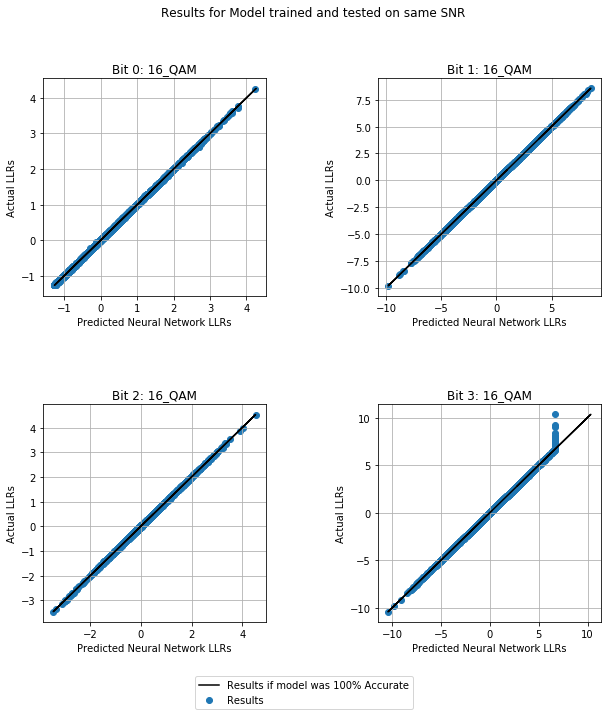

In [54]:
Image(filename="result_figures/16_QAM_train_snr_2_test_snr_2.png", width=500, height=500)

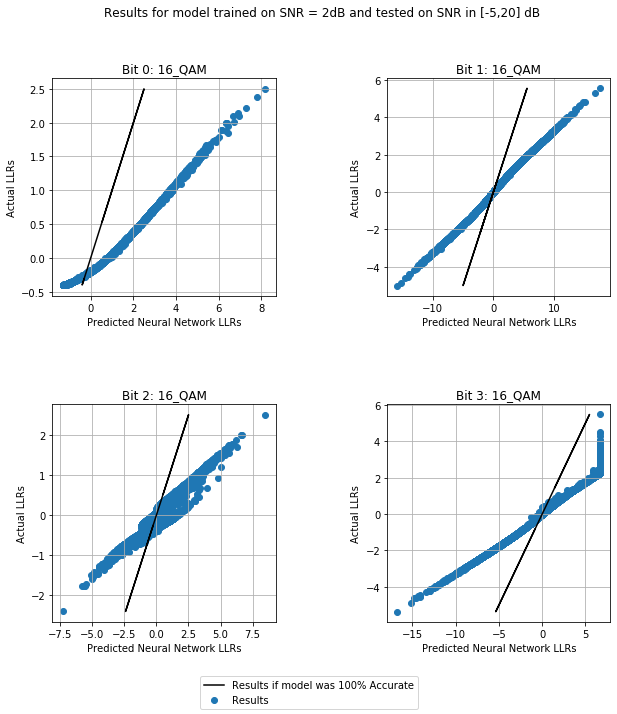

In [55]:
Image(filename="result_figures/16_QAM_train_snr_2_test_snr_-5_20.png", width=500, height=500)

### Training on multiple SNRs without fading

The figure below shows the results for a model trained on symbols with SNR ranging from -5 dB to 20 dB. This output indicates that the SNR range is too varied to make any meaningful training. The network, while trying to minimize the loss, clearly found that predicting an LLR of around 0, regardless of the input, was optimal. This indicates that, if we were to use this approach, we should train over a much narrower range of SNRs.

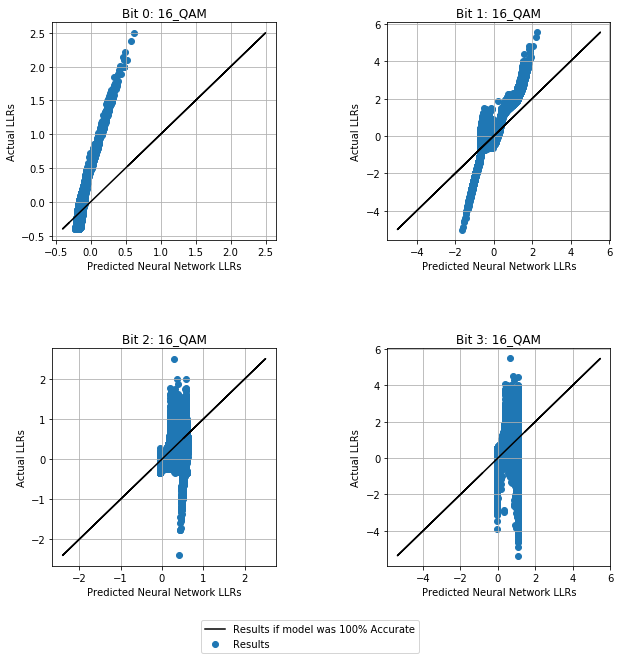

In [56]:
Image(filename="result_figures/16_QAM_train_snr_-5_20_test_snr_-5_20.png", width=500, height=500)

### Training on a single SNR with Fading

Training the model on data from a fading channel with AWGN noise, I saw the same issues as I did with training on $[-5, 20] dB$. The model performed slightly better, but the abundance of $0$ LLR predictions is still prevelant. I believe that it wasn't as much an issue of the attenutation, but rather the phase shift that caused this. I had set the variance of the fading model to be only 0.1 in order to lessen the effect of attenuation yet the model still predicted $0$ much more than what was reflected in the data. 



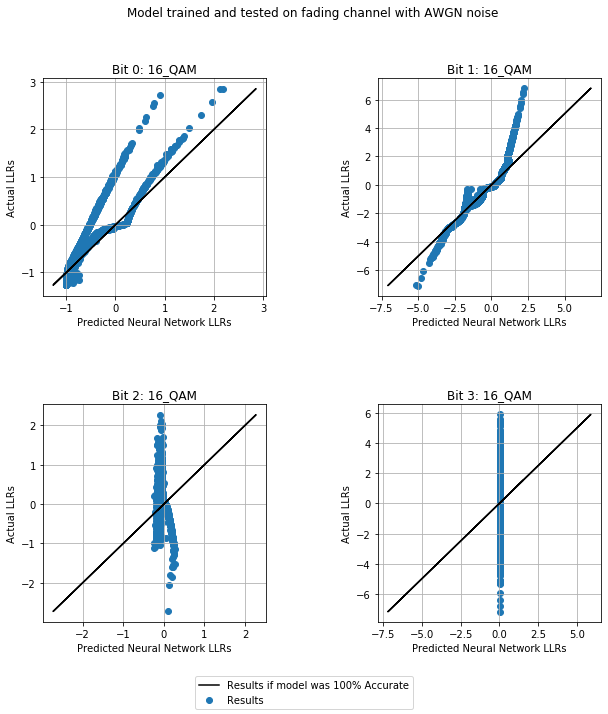

In [57]:
Image(filename="result_figures/16_QAM_train_fade_test_fade.png", width=500, height=500)

## Conclusion and Future Work

All in all, this data seems to suggest, for a non-fading channel with AWGN noise, a fully connected neural network can perform exceptionally well for predicting LLRs given just the in-phase and quadrature component of a symbol. This approach may be extended to range of SNRs but these SNRs must be close to the ones the model was trained at. As for fading, the model as it currently stands is not very effective at predicting LLRs, regardless of what AWGN SNR the model was trained at. Perhaps in the future, a more complex model can be implemented to address this. 
<br><br>
In the future, one may be able to extend this work to be compatible with fading channels. Or, going in a different direction, perhaps one can implmenet soft decoding using the LLRs generated by the Neural Network and compare the results to using the actuall LLRs. I was originally going to use the IEEE 802.11n LDPC code with blocklength = 1296 and plot the Frame Error Rate (FER) across various SNR, but was unable due to time constraints. 

# Begin the Code and Mount Google Drive to access files

In [4]:
!ls

data_files_multiple_snr     fdeep_model.json  result_figures
data_files_single_snr	    keras_export
data_files_single_snr_fade  llr_model.h5


In [0]:
# Can comment this line out if not using GPU
# Note that commenting this line out if your laptop has a GPU will result in slower training times
%%capture
!pip install tensorflow-gpu==2.1.0

## Import Required Libraries

In [0]:
import numpy as np
import scipy.io as sio
import sklearn
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, MaxPooling1D
from tensorflow.keras.layers import Activation,Conv2D, Flatten, Permute, Cropping2D
from tensorflow.keras.layers import ZeroPadding2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Reshape
from tensorflow.keras.layers import Conv1D, GRU
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
import matplotlib.pyplot as plt

# Load the Data

In [7]:
MODULATION = "BPSK"
SNR = "1.8"
FADE_VAR = "0.01"
SNR_RANGE_MIN = "1"
SNR_RANGE_MAX = "2.6"

# Load the training data
X_train_single_SNR = np.genfromtxt("./data_files_single_snr/" + MODULATION + "_X_train_snr_" + SNR + ".csv", delimiter=',')
y_train_single_SNR = np.genfromtxt("./data_files_single_snr/" + MODULATION + "_y_train_snr_" + SNR + ".csv", delimiter=',')
X_train_multiple_SNR = np.genfromtxt("./data_files_multiple_snr/" + MODULATION + "_X_train_snr_range_" + SNR_RANGE_MIN + "_" + SNR_RANGE_MAX + ".csv", delimiter=',')
y_train_multiple_SNR = np.genfromtxt("./data_files_multiple_snr/" + MODULATION + "_y_train_snr_range_" + SNR_RANGE_MIN + "_" + SNR_RANGE_MAX + ".csv", delimiter=',')
X_train_single_SNR_fade = np.genfromtxt("./data_files_single_snr_fade/" + MODULATION + "_X_train_snr_" + SNR + "_fade_var_" + FADE_VAR + ".csv", delimiter=',')
y_train_single_SNR_fade = np.genfromtxt("./data_files_single_snr_fade/" + MODULATION + "_y_train_snr_" + SNR + "_fade_var_" + FADE_VAR + ".csv", delimiter=',')

# Load validation data
X_valid_single_SNR = np.genfromtxt("./data_files_single_snr/" + MODULATION + "_X_valid_snr_" + SNR + ".csv", delimiter=',')
y_valid_single_SNR = np.genfromtxt("./data_files_single_snr/" + MODULATION + "_y_valid_snr_" + SNR + ".csv", delimiter=',')
X_valid_multiple_SNR = np.genfromtxt("./data_files_multiple_snr/" + MODULATION + "_X_valid_snr_range_" + SNR_RANGE_MIN + "_" + SNR_RANGE_MAX + ".csv", delimiter=',')
y_valid_multiple_SNR = np.genfromtxt("./data_files_multiple_snr/" + MODULATION + "_y_valid_snr_range_" + SNR_RANGE_MIN + "_" + SNR_RANGE_MAX + ".csv", delimiter=',')
X_valid_single_SNR_fade = np.genfromtxt("./data_files_single_snr_fade/" + MODULATION + "_X_valid_snr_" + SNR + "_fade_var_" + FADE_VAR + ".csv", delimiter=',')
y_valid_single_SNR_fade = np.genfromtxt("./data_files_single_snr_fade/" + MODULATION + "_y_valid_snr_" + SNR + "_fade_var_" + FADE_VAR + ".csv", delimiter=',')

# Load the test data
X_test_single_SNR = np.genfromtxt("./data_files_single_snr/" + MODULATION + "_X_test_snr_" + SNR + ".csv", delimiter=',')
y_test_single_SNR = np.genfromtxt("./data_files_single_snr/" + MODULATION + "_y_test_snr_" + SNR + ".csv", delimiter=',')
X_test_multiple_SNR = np.genfromtxt("./data_files_multiple_snr/" + MODULATION + "_X_test_snr_range_" + SNR_RANGE_MIN + "_" + SNR_RANGE_MAX + ".csv", delimiter=',')
y_test_multiple_SNR = np.genfromtxt("./data_files_multiple_snr/" + MODULATION + "_y_test_snr_range_" + SNR_RANGE_MIN + "_" + SNR_RANGE_MAX + ".csv", delimiter=',')
X_test_single_SNR_fade = np.genfromtxt("./data_files_single_snr_fade/" + MODULATION + "_X_test_snr_" + SNR + "_fade_var_" + FADE_VAR + ".csv", delimiter=',')
y_test_single_SNR_fade = np.genfromtxt("./data_files_single_snr_fade/" + MODULATION + "_y_test_snr_" + SNR + "_fade_var_" + FADE_VAR + ".csv", delimiter=',')

# Reshape the data
X_train_single_SNR = X_train_single_SNR.T
X_valid_single_SNR = X_valid_single_SNR.T
X_test_single_SNR = X_test_single_SNR.T
X_train_multiple_SNR = X_train_multiple_SNR.T
X_valid_multiple_SNR = X_valid_multiple_SNR.T
X_test_multiple_SNR = X_test_multiple_SNR.T
X_train_single_SNR_fade = X_train_single_SNR_fade.T
X_valid_single_SNR_fade = X_valid_single_SNR_fade.T
X_test_single_SNR_fade = X_test_single_SNR_fade.T

y_train_single_SNR = y_train_single_SNR.T
y_valid_single_SNR = y_valid_single_SNR.T
y_test_single_SNR = y_test_single_SNR.T
y_train_multiple_SNR = y_train_multiple_SNR.T
y_valid_multiple_SNR = y_valid_multiple_SNR.T
y_test_multiple_SNR = y_test_multiple_SNR.T
y_train_single_SNR_fade = y_train_single_SNR_fade.T
y_valid_single_SNR_fade = y_valid_single_SNR_fade.T
y_test_single_SNR_fade = y_test_single_SNR_fade.T

# Special case for M=2 since the data imported was only 1D
if(len(y_train_single_SNR.shape) == 1):
  y_train_single_SNR = y_train_single_SNR.reshape([-1,1])
  y_valid_single_SNR = y_valid_single_SNR.reshape([-1,1])
  y_test_single_SNR = y_test_single_SNR.reshape([-1,1])
  y_train_multiple_SNR = y_train_multiple_SNR.reshape([-1,1])
  y_valid_multiple_SNR = y_valid_multiple_SNR.reshape([-1,1])
  y_test_multiple_SNR = y_test_multiple_SNR.reshape([-1,1])
  y_train_single_SNR_fade = y_train_single_SNR_fade.reshape([-1,1])
  y_valid_single_SNR_fade = y_valid_single_SNR_fade.reshape([-1,1])
  y_test_single_SNR_fade = y_test_single_SNR_fade.reshape([-1,1])

print("Training data single SNR shape: \t\t", X_train_single_SNR.shape)
print("Validation data single SNR shape: \t\t",X_valid_single_SNR.shape)
print("Test data single SNR shape: \t\t\t" ,X_test_single_SNR.shape)

print()
print("Training label single SNR shape: \t\t", y_train_single_SNR.shape)
print("Validation label single SNR shape: \t\t", y_valid_single_SNR.shape)
print("Test label single SNR shape: \t\t\t", y_test_single_SNR.shape)

print("--------------------------------------------------------------------------")
print()
print("Training data multiple SNR shape: \t\t", X_train_multiple_SNR.shape)
print("Validation data multiple SNR shape: \t\t",X_valid_multiple_SNR.shape)
print("Test data multiple SNR shape: \t\t\t" ,X_test_multiple_SNR.shape)

print()
print("Training label multiple SNR shape: \t\t", y_train_multiple_SNR.shape)
print("Validation label multiple SNR shape: \t\t", y_valid_multiple_SNR.shape)
print("Test label multiple SNR shape: \t\t\t", y_test_multiple_SNR.shape)

print("--------------------------------------------------------------------------")
print()
print("Training data with fading shape: \t\t", X_train_single_SNR_fade.shape)
print("Validation data with fading shape: \t\t",X_valid_single_SNR_fade.shape)
print("Test data with fading shape: \t\t\t" ,X_test_single_SNR_fade.shape)

print()
print("Training label with fading shape: \t\t", y_train_single_SNR_fade.shape)
print("Validation label with fading shape: \t\t", y_valid_single_SNR_fade.shape)
print("Test label with fading shape: \t\t\t", y_test_single_SNR_fade.shape)

Training data single SNR shape: 		 (10000, 2)
Validation data single SNR shape: 		 (1500, 2)
Test data single SNR shape: 			 (3000, 2)

Training label single SNR shape: 		 (10000, 1)
Validation label single SNR shape: 		 (1500, 1)
Test label single SNR shape: 			 (3000, 1)
--------------------------------------------------------------------------

Training data multiple SNR shape: 		 (12750, 2)
Validation data multiple SNR shape: 		 (3825, 2)
Test data multiple SNR shape: 			 (7650, 2)

Training label multiple SNR shape: 		 (12750, 1)
Validation label multiple SNR shape: 		 (3825, 1)
Test label multiple SNR shape: 			 (7650, 1)
--------------------------------------------------------------------------

Training data with fading shape: 		 (10000, 2)
Validation data with fading shape: 		 (1500, 2)
Test data with fading shape: 			 (3000, 2)

Training label with fading shape: 		 (10000, 1)
Validation label with fading shape: 		 (1500, 1)
Test label with fading shape: 			 (3000, 1)


# Construct Fully Connected Neural Net trained on a single SNR


## Define the first model. Note that we have multiple outputs corresponding to each bit LLR.

In [36]:
model_input = Input(shape=(X_train_single_SNR.shape[1]), name='model_input')
num_outputs = y_train_single_SNR.shape[1]
num_layers = 7

# Create Dense Layers; these layers are shared between ALL outputs
x = Dense(256, activation='relu')(model_input)
for i in range(num_layers, 1, -1):
  x = Dense(max(num_outputs*2, 2**i), activation="relu")(x)

# Create more Dense layers that are unique to each output
output_vec = [None]*num_outputs
for i in range(num_outputs):
  out_layer_name = "LLR_bit_" + str(i+1)
  bit_layer = Dense(4, activation  = 'relu', name = "bit_layer_" + str(i + 1))(x)
  output_vec[i] = Dense(1, activation = "linear", name = out_layer_name)(bit_layer)

model = Model(inputs = model_input, outputs = output_vec)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_input (InputLayer)     [(None, 2)]               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               768       
_________________________________________________________________
dense_14 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_15 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_16 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_17 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 136 

## Train the model on single SNR

In [0]:
# Experimented with model parameters:
# Can choose loss function, metrics, optimizer parameters
model.compile(loss='logcosh',
              optimizer = optimizers.Nadam(),
              metrics = ['mean_squared_error'])

# Since we have one output per bit, store the results of each its own list
y_train_flattened = [None] * num_outputs
y_valid_flattened = [None] * num_outputs
y_test_flattened = [None] * num_outputs

# Load the list with the LLRs of each bit
for i in range(num_outputs):
  y_train_flattened[i] = y_train_single_SNR[:,i]
  y_valid_flattened[i] = y_valid_single_SNR[:,i]
  y_test_flattened[i] = y_test_single_SNR[:,i]

# Train the model finally
history = model.fit(X_train_single_SNR, y_train_flattened, validation_data=(X_valid_single_SNR, y_valid_flattened), batch_size=50, epochs=100, verbose = 0)

## Evaluate the Model on the same SNR
<a id='16_QAM_train_test_2dB'></a>

In [43]:
# Test model on the validation and test set and report results
score_val = model.evaluate(X_valid_single_SNR, y_valid_flattened, batch_size = 100, verbose=0)
score_test = model.evaluate(X_test_single_SNR, y_test_flattened, batch_size = 100, verbose=0)

print("Evaluate model on the validation set:")
print("---------------------------------------------------")
print("Total Loss: \t\t\t", score_val[0])
for i in range(num_outputs):
  print("Bit " + str(i) + " [Loss, MSE] is: \t\t", score_val[i+ (num_outputs != 1)], "\t, ", score_val[i+ 1 + 2*(num_outputs != 1)])

print("\n\nEvaluate model on the test set:")
print("---------------------------------------------------")
print("Total Loss: \t\t\t", score_test[0])
for i in range(num_outputs):
  print("Bit " + str(i) + " [Loss, MSE] is: \t\t", score_test[i+ (num_outputs != 1)], "\t, ", score_test[i+ 1 + 2*(num_outputs != 1)])

Evaluate model on the validation set:
---------------------------------------------------
Total Loss: 			 3.725562540542645e-05
Bit 0 [Loss, MSE] is: 		 3.725562540542645e-05 	,  7.4521595e-05


Evaluate model on the test set:
---------------------------------------------------
Total Loss: 			 3.606085756473476e-05
Bit 0 [Loss, MSE] is: 		 3.606085756473476e-05 	,  7.21287e-05


### Plot the LLRs acquired from the neural net vs actual LLRs`

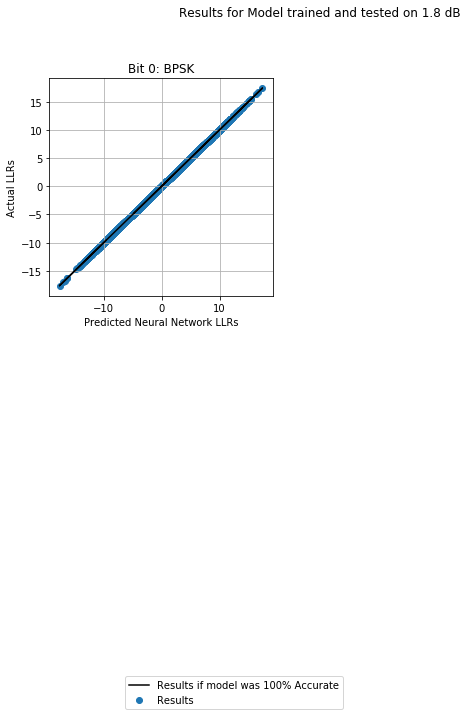

In [44]:
y_pred = [None]*num_outputs
y_pred = model.predict(X_test_single_SNR)

f = plt.figure()
f.set_figheight(10)
f.set_figwidth(10)
for i in range(num_outputs):
  if num_outputs != 1:
    predicted = y_pred[i][:]
  else:
    predicted = y_pred

  plt.subplot(2,2,i+1)
  plt.scatter(np.asarray(predicted), y_test_single_SNR[:,i].reshape([-1,1]))
  plt.plot(y_test_single_SNR[:,i].reshape([-1,1]), y_test_single_SNR[:,i].reshape([-1,1]), 'k')
  plt.xlabel("Predicted Neural Network LLRs")
  plt.ylabel("Actual LLRs")
  plt.title("Bit " + str(i) + ": " + MODULATION)
  plt.grid()

plt.subplots_adjust(wspace=0.5, hspace=0.5)
f.legend(('Results if model was 100% Accurate', 'Results', ), loc = 'lower center')
f.suptitle("Results for Model trained and tested on " + str(SNR) + " dB")
plt.show()

In [45]:
model_multiple_snr.save('llr_bpsk_model_single.h5', include_optimizer=False)

!python3 keras_export/convert_model.py llr_model.h5 bpsk_single.json

2020-03-15 09:50:50.131534: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2020-03-15 09:50:50.131691: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2020-03-15 09:50:50.131712: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
loading llr_model.h5
2020-03-15 09:50:51.296239: E tensorflow/stream_executor/cuda/cuda_driver.cc:351] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CU

## Evaluate the Model on various SNR

In [9]:
y_test_flattened = [None] * num_outputs

for i in range(num_outputs):
  y_test_flattened[i] = y_test_multiple_SNR[:,i]

# Test model on the validation and test set and report results
score_test = model.evaluate(X_test_multiple_SNR, y_test_flattened, batch_size = 100, verbose=0)

print("Evaluate model on multiple SNR:")
print("---------------------------------------------------")
print("Total Loss: \t\t\t", score_test[0])
for i in range(num_outputs):
  print("Bit " + str(i) + " [Loss, MSE] is: \t\t", score_test[i+ (num_outputs != 1)], "\t, ", score_test[i+ 1 + 2*(num_outputs != 1)])

RuntimeError: ignored

### Plot the LLRs acquired from the neural net vs actual LLRs

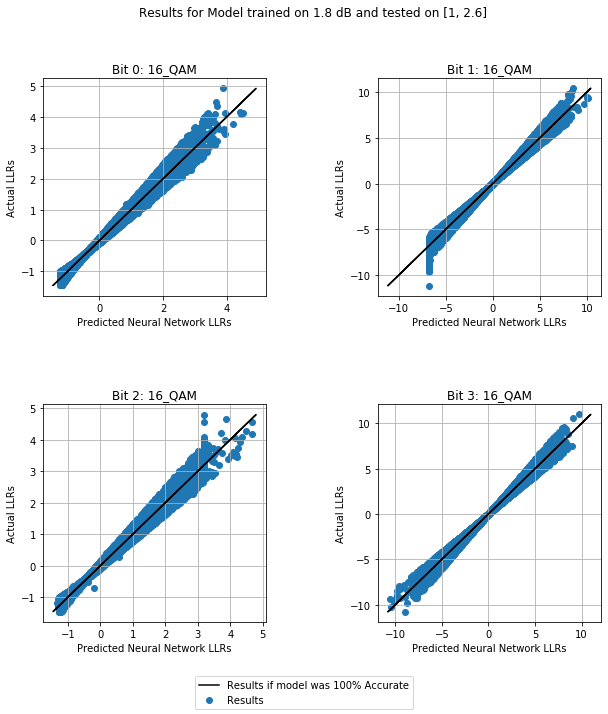

In [67]:
y_pred = [None]*num_outputs
y_pred = model.predict(X_test_multiple_SNR)

f = plt.figure()
f.set_figheight(10)
f.set_figwidth(10)
for i in range(num_outputs):
  if num_outputs != 1:
    predicted = y_pred[i][:]
  else:
    predicted = y_pred

  plt.subplot(2,2,i+1)
  plt.scatter(np.asarray(predicted), y_test_multiple_SNR[:,i].reshape([-1,1]))
  plt.plot(y_test_multiple_SNR[:,i].reshape([-1,1]), y_test_multiple_SNR[:,i].reshape([-1,1]), 'k')
  plt.xlabel("Predicted Neural Network LLRs")
  plt.ylabel("Actual LLRs")
  plt.title("Bit " + str(i) + ": " + MODULATION)
  plt.grid()

f.legend(('Results if model was 100% Accurate', 'Results', ), loc = 'lower center')
f.suptitle("Results for Model trained on " + str(SNR) + " dB" " and tested on [" + str(SNR_RANGE_MIN) + ", " + str(SNR_RANGE_MAX) + "]" )
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

# Construct Fully Connected Neural Net trained on multiple SNR

## Define the second model. Note that we have multiple outputs corresponding to each bit LLR.

In [8]:
model_input = Input(shape=(X_train_multiple_SNR.shape[1]), name='model_input')
num_outputs = y_train_multiple_SNR.shape[1]
num_layers = 6

x = Dense(128, activation='relu')(model_input)
for i in range(num_layers, 1, -1):
  x = Dense(max(num_outputs*2, 2**i), activation="relu")(x)

output_vec = [None]*num_outputs
for i in range(num_outputs):
  out_layer_name = "LLR_bit_" + str(i+1)
  bit_layer = Dense(4, activation  = 'relu', name = "bit_layer_" + str(i + 1))(x)
  output_vec[i] = Dense(1, activation = "linear", name = out_layer_name)(bit_layer)

model_multiple_snr = Model(inputs = model_input, outputs = output_vec)
model_multiple_snr.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_input (InputLayer)     [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 128)               384       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 36    

## Train the model on multiple SNR

In [0]:
# Experimented with model parameters:
# Can choose loss function, metrics, optimizer parameters
model_multiple_snr.compile(loss='logcosh',
              optimizer = optimizers.Nadam(),
              metrics = ['mean_squared_error'])

# Since we have one output per bit, store the results of each its own list
y_train_flattened = [None] * num_outputs
y_valid_flattened = [None] * num_outputs
y_test_flattened = [None] * num_outputs

for i in range(num_outputs):
  y_train_flattened[i] = y_train_multiple_SNR[:,i]
  y_valid_flattened[i] = y_valid_multiple_SNR[:,i]
  y_test_flattened[i] = y_test_multiple_SNR[:,i]

history = model_multiple_snr.fit(X_train_multiple_SNR, y_train_flattened, validation_data=(X_valid_multiple_SNR, y_valid_flattened), batch_size=50, epochs=100, verbose = 0)

## Evaluate the model on a various SNR

In [38]:
y_valid_flattened = [None] * num_outputs
y_test_flattened = [None] * num_outputs

for i in range(num_outputs):
  y_valid_flattened[i] = y_valid_multiple_SNR[:,i]
  y_test_flattened[i] = y_test_multiple_SNR[:,i]

# Test model on the validation and test set and report results
score_val = model_multiple_snr.evaluate(X_valid_multiple_SNR, y_valid_flattened, batch_size = 100, verbose=0)
score_test = model_multiple_snr.evaluate(X_test_multiple_SNR, y_test_flattened, batch_size = 100, verbose=0)

print("Evaluate model on the validation set:")
print("---------------------------------------------------")
print("Total Loss: \t\t\t", score_val[0])
for i in range(num_outputs):
  print("Bit " + str(i) + " [Loss, MSE] is: \t\t", score_val[i+ (num_outputs != 1)], "\t, ", score_val[i+ 1 + 2*(num_outputs != 1)])

print("\n\nEvaluate model on the test set:")
print("---------------------------------------------------")
print("Total Loss: \t\t\t", score_test[0])
for i in range(num_outputs):
  print("Bit " + str(i) + " [Loss, MSE] is: \t\t", score_test[i+ (num_outputs != 1)], "\t, ", score_test[i+ 1 + 2*(num_outputs != 1)])

Evaluate model on the validation set:
---------------------------------------------------
Total Loss: 			 0.2509582158592012
Bit 0 [Loss, MSE] is: 		 0.2509582158592012 	,  0.6393128


Evaluate model on the test set:
---------------------------------------------------
Total Loss: 			 0.243916877034102
Bit 0 [Loss, MSE] is: 		 0.243916877034102 	,  0.61294144


### Plot the LLRs acquired from the neural net vs actual LLRs`

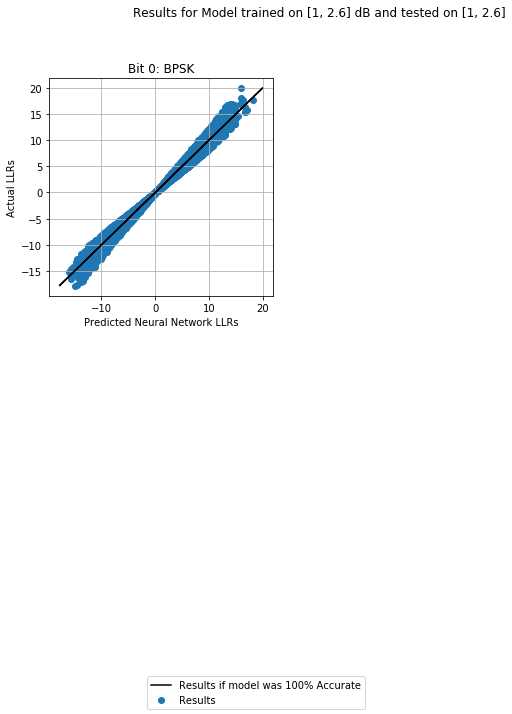

In [39]:
y_pred = [None]*num_outputs
y_pred = model_multiple_snr.predict(X_test_multiple_SNR)

f = plt.figure()
f.set_figheight(10)
f.set_figwidth(10)
for i in range(num_outputs):
  if num_outputs != 1:
    predicted = y_pred[i][:]
  else:
    predicted = y_pred

  plt.subplot(2,2,i+1)
  plt.scatter(np.asarray(predicted), y_test_multiple_SNR[:,i].reshape([-1,1]))
  plt.plot(y_test_multiple_SNR[:,i].reshape([-1,1]), y_test_multiple_SNR[:,i].reshape([-1,1]), 'k')
  plt.xlabel("Predicted Neural Network LLRs")
  plt.ylabel("Actual LLRs")
  plt.title("Bit " + str(i) + ": " + MODULATION)
  plt.grid()

f.legend(('Results if model was 100% Accurate', 'Results', ), loc = 'lower center')
f.suptitle("Results for Model trained on [" + str(SNR_RANGE_MIN) + ", " + str(SNR_RANGE_MAX) + "]" + " dB" " and tested on [" + str(SNR_RANGE_MIN) + ", " + str(SNR_RANGE_MAX) + "]" )
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

In [12]:
model_multiple_snr.save('llr_bpsk_model.h5', include_optimizer=False)

!python3 keras_export/convert_model.py llr_model.h5 fdeep_model.json


2020-03-15 08:48:12.544187: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2020-03-15 08:48:12.544292: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2020-03-15 08:48:12.544307: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
loading llr_model.h5
2020-03-15 08:48:13.831396: E tensorflow/stream_executor/cuda/cuda_driver.cc:351] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CU

In [27]:
x = np.array([1.1,2.2]).reshape([-1,1]).T

model_multiple_snr.predict(x)


[array([[0.8118974]], dtype=float32),
 array([[-3.3678126]], dtype=float32),
 array([[2.994915]], dtype=float32),
 array([[7.1531096]], dtype=float32)]

# Construct Fully Connected Nerual Net trained on Single SNR with Fading

## Define the third model. Note that we have multiple outputs corresponding to each bit LLR.

In [73]:
model_input = Input(shape=(X_train_single_SNR_fade.shape[1]), name='model_input')
num_outputs = y_train_single_SNR_fade.shape[1]
num_layers = 6

x = Dense(128, activation='relu')(model_input)
x = Dropout(0.5)(x)
for i in range(num_layers, 1, -1):
  x = Dense(max(num_outputs*2, 2**i), activation="relu")(x)

output_vec = [None]*num_outputs
for i in range(num_outputs):
  out_layer_name = "LLR_bit_" + str(i+1)
  bit_layer = Dense(4, activation  = 'relu', name = "bit_layer_" + str(i + 1))(x)
  output_vec[i] = Dense(1, activation = "linear", name = out_layer_name)(bit_layer)

model_fade = Model(inputs = model_input, outputs = output_vec)
model_fade.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
model_input (InputLayer)        [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_50 (Dense)                (None, 128)          384         model_input[0][0]                
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 128)          0           dense_50[0][0]                   
__________________________________________________________________________________________________
dense_51 (Dense)                (None, 64)           8256        dropout_3[0][0]                  
____________________________________________________________________________________________

## Train the model on faded symbols with AWGN noise

In [74]:
# Experimented with model parameters:
# Can choose loss function, metrics, optimizer parameters
model_fade.compile(loss='logcosh',
              optimizer = optimizers.Nadam(),
              metrics = ['mean_squared_error'])

# Since we have one output per bit, store the results of each its own list
y_train_flattened = [None] * num_outputs
y_valid_flattened = [None] * num_outputs
y_test_flattened = [None] * num_outputs

for i in range(num_outputs):
  y_train_flattened[i] = y_train_single_SNR_fade[:,i]
  y_valid_flattened[i] = y_valid_single_SNR_fade[:,i]
  y_test_flattened[i] = y_test_single_SNR_fade[:,i]

history = model_fade.fit(X_train_single_SNR_fade, y_train_flattened, validation_data=(X_valid_single_SNR_fade, y_valid_flattened), batch_size=50, epochs=100, verbose = 0)

KeyboardInterrupt: ignored

## Evaluate the model on single SNR with fading

In [0]:
y_valid_flattened = [None] * num_outputs
y_test_flattened = [None] * num_outputs

for i in range(num_outputs):
  y_valid_flattened[i] = y_valid_single_SNR_fade[:,i]
  y_test_flattened[i] = y_test_single_SNR_fade[:,i]

# Test model on the validation and test set and report results
score_val = model_fade.evaluate(X_valid_single_SNR_fade, y_valid_flattened, batch_size = 100, verbose=0)
score_test = model_fade.evaluate(X_test_single_SNR_fade, y_test_flattened, batch_size = 100, verbose=0)

print("Evaluate model on the validation set:")
print("---------------------------------------------------")
print("Total Loss: \t\t\t", score_val[0])
for i in range(num_outputs):
  print("Bit " + str(i) + " [Loss, MSE] is: \t\t", score_val[i+ int(num_outputs != 1)], "\t, ", score_val[i+ 1 + 2*int(num_outputs != 1)])

print("\n\nEvaluate model on the test set:")
print("---------------------------------------------------")
print("Total Loss: \t\t\t", score_test[0])
for i in range(num_outputs):
  print("Bit " + str(i) + " [Loss, MSE] is: \t\t", score_test[i+ int(num_outputs != 1)], "\t, ", score_test[i+ 1 + 2*int(num_outputs != 1)])

In [0]:
y_pred = [None]*num_outputs
y_pred = model_fade.predict(X_test_single_SNR_fade)

f = plt.figure()
f.set_figheight(10)
f.set_figwidth(10)
for i in range(num_outputs):
  if num_outputs != 1:
    predicted = y_pred[i][:]
  else:
    predicted = y_pred

  plt.subplot(2,2,i+1)
  plt.scatter(np.asarray(predicted), y_test_single_SNR_fade[:,i].reshape([-1,1]))
  plt.plot(y_test_single_SNR_fade[:,i].reshape([-1,1]), y_test_single_SNR_fade[:,i].reshape([-1,1]), 'k')
  plt.xlabel("Predicted Neural Network LLRs")
  plt.ylabel("Actual LLRs")
  plt.title("Bit " + str(i) + ": " + MODULATION)
  plt.grid()

f.legend(('Results if model was 100% Accurate', 'Results', ), loc = 'lower center')
f.suptitle("Model trained and tested on Rayleigh fading channel with variance " + str(FADE_VAR) + " and AWGN noise")
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()